<h2>1. Analysis</h2>

Importing all the necessary libaries

In [17]:
import os
import re
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
import pandas as pd
import tokenize
from io import BytesIO

Same Documents are used as what we used for Assignment 1

In [2]:
folder_path = '/kaggle/input/documents-are-in-this/documents' 

Gathering all the text

In [3]:
all_text = ""
for filename in os.listdir(folder_path):
    if filename.endswith(".txt"):
        with open(os.path.join(folder_path, filename), 'r', encoding='utf-8', errors='ignore') as file:
            all_text += file.read() + " "

Tokenizing all the text now

In [4]:
tokens = re.findall(r'\b[a-z]+\b', all_text.lower())

# Step 4: Count word frequencies
word_counts = Counter(tokens)

# Step 5: Sort by frequency
sorted_counts = word_counts.most_common()

In [5]:
# Step 6: Prepare rank and frequency lists
ranks = np.arange(1, len(sorted_counts) + 1)
frequencies = np.array([freq for word, freq in sorted_counts])

Plotting the graph for frequency vs rank

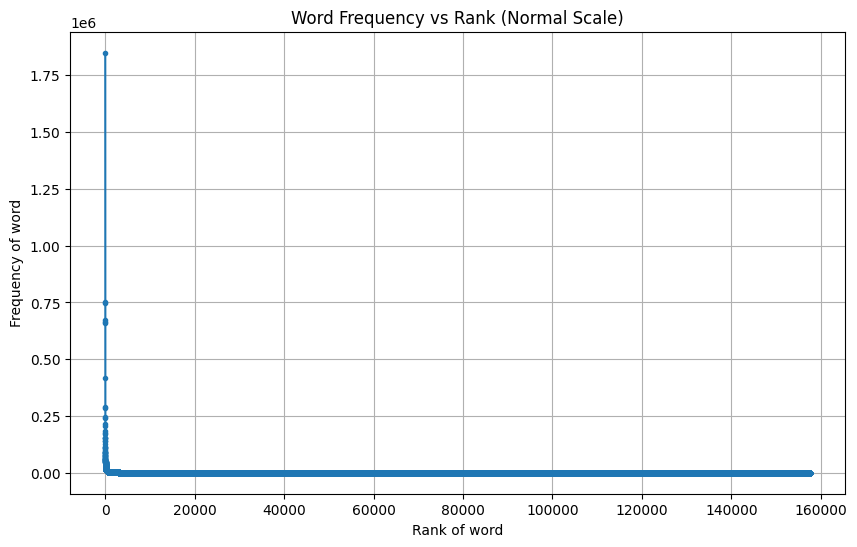

In [6]:
# Normal plot
plt.figure(figsize=(10, 6))
plt.plot(ranks, frequencies, marker=".")
plt.title("Word Frequency vs Rank (Normal Scale)")
plt.xlabel("Rank of word")
plt.ylabel("Frequency of word")
plt.grid(True)
plt.show()

Plotting the log for the same

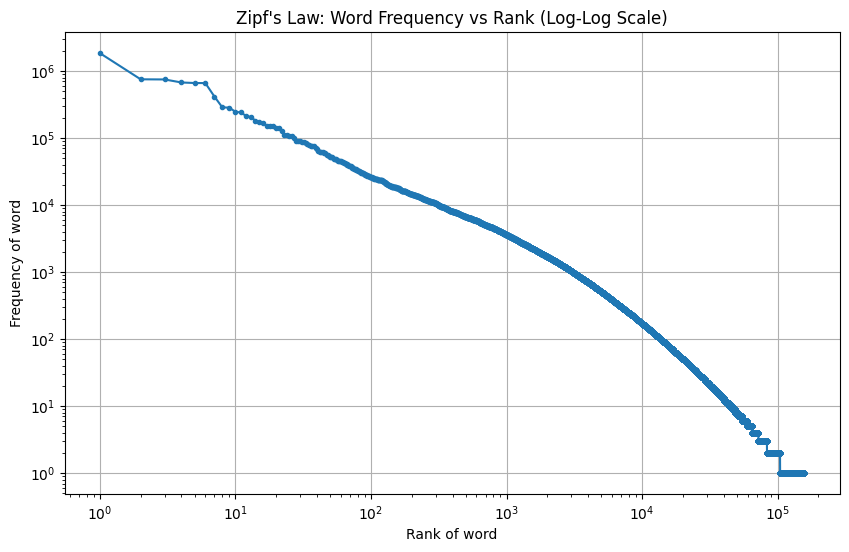

In [7]:
# Log-log plot
plt.figure(figsize=(10, 6))
plt.loglog(ranks, frequencies, marker=".")
plt.title("Zipf's Law: Word Frequency vs Rank (Log-Log Scale)")
plt.xlabel("Rank of word")
plt.ylabel("Frequency of word")
plt.grid(True)
plt.show()

Now, by Linear Regression, we will fit a line in the above plot and if it follows the zipf's law perfectly, it should have a slope of -1, and around -1, if it is not perfect but still follows zipf'law approximately

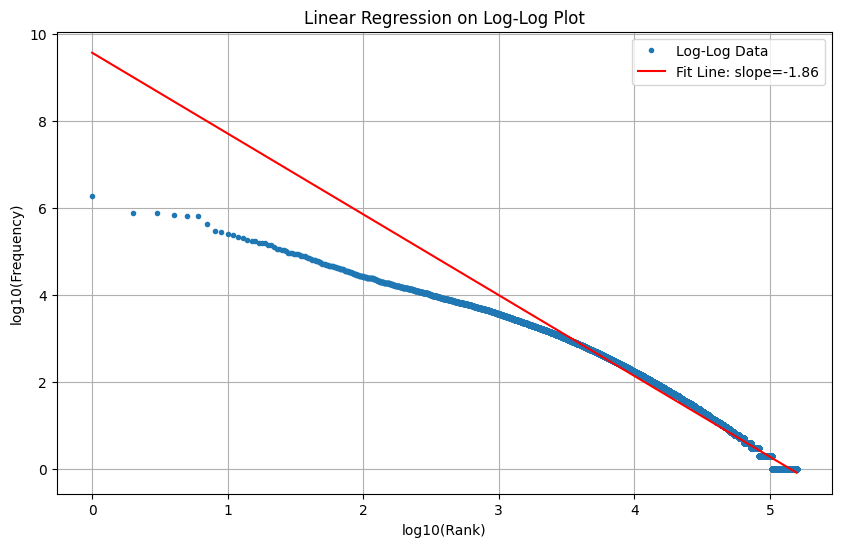

Slope of the fitted line: -1.8578


In [8]:
# Step 1: Convert to log scale
log_ranks = np.log10(ranks)
log_freqs = np.log10(frequencies)

# Step 2: Fit linear regression
slope, intercept, r_value, p_value, std_err = linregress(log_ranks, log_freqs)

# Step 3: Plot with regression line
plt.figure(figsize=(10, 6))
plt.plot(log_ranks, log_freqs, '.', label='Log-Log Data')
plt.plot(log_ranks, intercept + slope * log_ranks, 'r', label=f'Fit Line: slope={slope:.2f}')
plt.title("Linear Regression on Log-Log Plot")
plt.xlabel("log10(Rank)")
plt.ylabel("log10(Frequency)")
plt.legend()
plt.grid(True)
plt.show()

# Step 4: Print slope
print(f"Slope of the fitted line: {slope:.4f}")

So the law is not perfectly fitting here, as the slope should have been -1 or around that

<h2>2. Decrypt Messages</h2>

<h3>2.1 Removing the noise</h3>

So the major logic here comes on to the fact that, real messages will follow the pattern of natural language and will follow zipf's law but noise won't follow zipf's law and that is because, it doesn't follow the pattern of natural language in the 1st place.

In this segment, we are trying to understand the data as to what is the distribution of the data, so that we can keep thresholds for determining noise and real messages accordingly

[PROGRESS] Processed 100/5000 files.
[PROGRESS] Processed 200/5000 files.
[PROGRESS] Processed 300/5000 files.
[PROGRESS] Processed 400/5000 files.
[PROGRESS] Processed 500/5000 files.
[PROGRESS] Processed 600/5000 files.
[PROGRESS] Processed 700/5000 files.
[PROGRESS] Processed 800/5000 files.
[PROGRESS] Processed 900/5000 files.
[PROGRESS] Processed 1000/5000 files.
[PROGRESS] Processed 1100/5000 files.
[PROGRESS] Processed 1200/5000 files.
[PROGRESS] Processed 1300/5000 files.
[PROGRESS] Processed 1400/5000 files.
[PROGRESS] Processed 1500/5000 files.
[PROGRESS] Processed 1600/5000 files.
[PROGRESS] Processed 1700/5000 files.
[PROGRESS] Processed 1800/5000 files.
[PROGRESS] Processed 1900/5000 files.
[PROGRESS] Processed 2000/5000 files.
[PROGRESS] Processed 2100/5000 files.
[PROGRESS] Processed 2200/5000 files.
[PROGRESS] Processed 2300/5000 files.
[PROGRESS] Processed 2400/5000 files.
[PROGRESS] Processed 2500/5000 files.
[PROGRESS] Processed 2600/5000 files.
[PROGRESS] Processed 

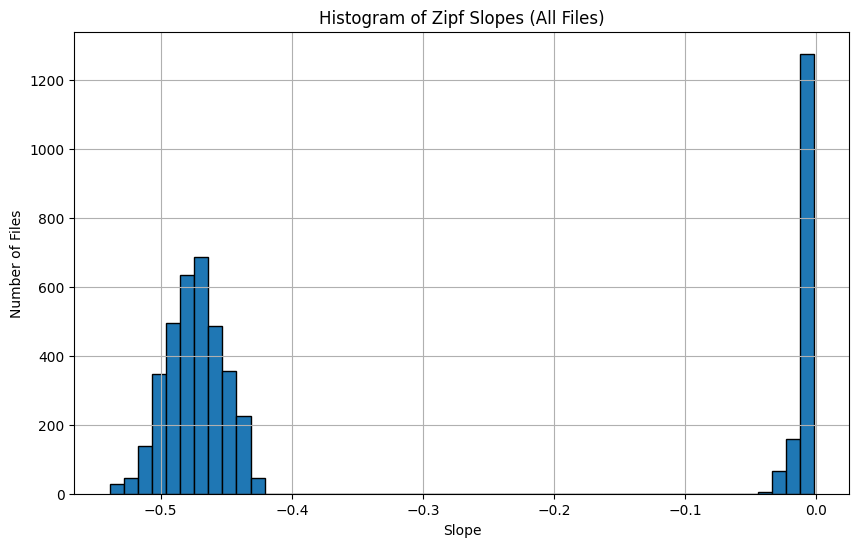

In [11]:
# Path to all files
data_folder = '/kaggle/input/same-data-only'  # Replace with your actual folder name
TOTAL_PAIRS = 5000

slopes = []

def compute_zipf_slope(text):
    words = [
        word.lower()
        for word in re.findall(r'\b[a-zA-Z]+\b', text)
        if not word.lower().startswith("t_")
    ]

    if len(words) < 20:
        return None

    freq_counter = Counter(words)
    sorted_freqs = [freq for word, freq in freq_counter.most_common()]

    ranks = np.arange(1, len(sorted_freqs) + 1)
    freqs = np.array(sorted_freqs)

    log_ranks = np.log10(ranks)
    log_freqs = np.log10(freqs)

    slope, _, _, _, _ = linregress(log_ranks, log_freqs)
    return slope

# Process all message-token pairs
for i in range(TOTAL_PAIRS):
    encoded_path = os.path.join(data_folder, f"message_{i+1}_encoded.txt")
    shuffled_path = os.path.join(data_folder, f"message_{i+1}_shuffled.txt")

    try:
        with open(encoded_path, "r", encoding="utf-8") as f1, open(shuffled_path, "r", encoding="utf-8") as f2:
            combined_text = f1.read() + "\n" + f2.read()
            slope = compute_zipf_slope(combined_text)
            slopes.append(slope if slope is not None else np.nan)
    except Exception as e:
        print(f"[{i}] Error: {e}")
        slopes.append(np.nan)

    if (i + 1) % 100 == 0:
        print(f"[PROGRESS] Processed {i + 1}/{TOTAL_PAIRS} files.")

# Convert to DataFrame and save for inspection
df = pd.DataFrame({'file_index': range(TOTAL_PAIRS), 'slope': slopes})
df.to_csv("slope_values.csv", index=False)
print("[INFO] Saved slope_values.csv")

# Plot histogram of slope values
valid_slopes = df['slope'].dropna()
plt.figure(figsize=(10, 6))
plt.hist(valid_slopes, bins=50, edgecolor='black')
plt.title("Histogram of Zipf Slopes (All Files)")
plt.xlabel("Slope")
plt.ylabel("Number of Files")
plt.grid(True)
plt.show()


From the above plot, we can see it is basically around -0.6 to -0.4 where we can find the real messages, while the outliers are noise messages

In [12]:
# Set folder path containing all 10k files
data_folder = '/kaggle/input/same-data-only'  # Replace with actual path

# Total number of message pairs
TOTAL_PAIRS = 5000

# Store 0 or 1 for each message
mask = []

def is_zipf_like(text, slope_threshold=(-0.7, -0.4), file_index=None):
    words = [
        word.lower()
        for word in re.findall(r'\b[a-zA-Z]+\b', text)
        if not word.lower().startswith("t_")
    ]

    if len(words) < 20:
        print(f"[{file_index}] Too few words, marked as noise.")
        return False

    freq_counter = Counter(words)
    sorted_freqs = [freq for word, freq in freq_counter.most_common()]

    ranks = np.arange(1, len(sorted_freqs) + 1)
    freqs = np.array(sorted_freqs)

    log_ranks = np.log10(ranks)
    log_freqs = np.log10(freqs)

    slope, intercept, r_val, p_val, std_err = linregress(log_ranks, log_freqs)

    # if file_index is not None:
    #     print(f"[{file_index}] Slope: {slope:.4f} → {'Real' if slope_threshold[0] <= slope <= slope_threshold[1] else 'Noise'}")

    return slope_threshold[0] <= slope <= slope_threshold[1]

In [13]:
# Process all pairs
for i in range(TOTAL_PAIRS):
    encoded_path = os.path.join(data_folder, f"message_{i+1}_encoded.txt")
    shuffled_path = os.path.join(data_folder, f"message_{i+1}_shuffled.txt")

    try:
        with open(encoded_path, "r", encoding="utf-8") as f1, open(shuffled_path, "r", encoding="utf-8") as f2:
            text = f1.read() + "\n" + f2.read()
            label = 0 if is_zipf_like(text, file_index=i) else 1
            mask.append(label)
    except Exception as e:
        print(f"[{i}] Error reading files: {e} → Marked as noise.")
        mask.append(1)

    if (i + 1) % 100 == 0:
        print(f"[PROGRESS] Processed {i + 1}/{TOTAL_PAIRS} files.")

# Write output
with open("mask.txt", "w") as fout:
    for label in mask:
        fout.write(f"{label}\n")

print("[DONE] Results saved to mask.txt")

[PROGRESS] Processed 100/5000 files.
[PROGRESS] Processed 200/5000 files.
[PROGRESS] Processed 300/5000 files.
[PROGRESS] Processed 400/5000 files.
[PROGRESS] Processed 500/5000 files.
[PROGRESS] Processed 600/5000 files.
[PROGRESS] Processed 700/5000 files.
[PROGRESS] Processed 800/5000 files.
[PROGRESS] Processed 900/5000 files.
[PROGRESS] Processed 1000/5000 files.
[PROGRESS] Processed 1100/5000 files.
[PROGRESS] Processed 1200/5000 files.
[PROGRESS] Processed 1300/5000 files.
[PROGRESS] Processed 1400/5000 files.
[PROGRESS] Processed 1500/5000 files.
[PROGRESS] Processed 1600/5000 files.
[PROGRESS] Processed 1700/5000 files.
[PROGRESS] Processed 1800/5000 files.
[PROGRESS] Processed 1900/5000 files.
[PROGRESS] Processed 2000/5000 files.
[PROGRESS] Processed 2100/5000 files.
[PROGRESS] Processed 2200/5000 files.
[PROGRESS] Processed 2300/5000 files.
[PROGRESS] Processed 2400/5000 files.
[PROGRESS] Processed 2500/5000 files.
[PROGRESS] Processed 2600/5000 files.
[PROGRESS] Processed 

In [14]:
# Count final results
num_real = mask.count(0)
num_noise = mask.count(1)

print("\n=== Classification Summary ===")
print(f"Total messages:     {len(mask)}")
print(f"Real messages (0):  {num_real}")
print(f"Noise messages (1): {num_noise}")
print("==============================")


=== Classification Summary ===
Total messages:     5000
Real messages (0):  3491
Noise messages (1): 1509


<h3>2.2 Decryption</h3>

Now, we will try to decrypt the messages using the Frequency Distribution since the mapping is given to be bijective (which is obvious or we cannot solve this problem)<br>

For frequency ties, we are choosing randomly here but we can increase the accuracy by using the context of the surrounding words by using 
1. n-gram models
2. capturing context through language models or LLMs

In [24]:
# Paths
data_folder = '/kaggle/input/same-data-only'  # Update as needed
mask_path = '/kaggle/working/mask.txt'
output_folder = '/kaggle/working/decrypted_messages'

# Create output folder
os.makedirs(output_folder, exist_ok=True)

# Load mask file
with open(mask_path, 'r') as f:
    mask = [int(line.strip()) for line in f.readlines()]

# Token pattern
token_pattern = r't_\d+'

# Word pattern
word_pattern = r'\b[a-zA-Z]+\b'

# Process each real message
for i in range(len(mask)):
    if mask[i] == 1:
        continue  # Skip noise

    # File paths
    encoded_path = os.path.join(data_folder, f"message_{i+1}_encoded.txt")
    shuffled_path = os.path.join(data_folder, f"message_{i+1}_shuffled.txt")
    output_path = os.path.join(output_folder, f"message_{i+1}.txt")

    try:
        # Read files
        with open(encoded_path, 'r', encoding='utf-8') as f:
            encoded_text = f.read()
        with open(shuffled_path, 'r', encoding='utf-8') as f:
            shuffled_text = f.read()

        # Token frequencies
        tokens = re.findall(token_pattern, encoded_text)
        token_freq = Counter(tokens)

        # Word frequencies from shuffled file
        words = [w.lower() for w in re.findall(word_pattern, shuffled_text) if not w.lower().startswith('t_')]
        word_freq = Counter(words)

        # Sort tokens and words
        sorted_tokens = sorted(token_freq.items(), key=lambda x: (-x[1], x[0]))  # by freq desc, then name
        sorted_words = sorted(word_freq.items(), key=lambda x: (-x[1], x[0]))    # by freq desc, then alpha

        # Build mapping
        mapping = {token: word for (token, _), (word, _) in zip(sorted_tokens, sorted_words)}

        # Replace tokens in original message
        def substitute_token(match):
            tok = match.group(0)
            return mapping.get(tok, tok)

        decrypted_text = re.sub(token_pattern, substitute_token, encoded_text)

        # Save decrypted message
        with open(output_path, 'w', encoding='utf-8') as f:
            f.write(decrypted_text)

    except Exception as e:
        print(f"[ERROR] message_{i}: {e}")

print("[DONE] All real messages decrypted to: /kaggle/working/decrypted_messages/")


[DONE] All real messages decrypted to: /kaggle/working/decrypted_messages/


<h3>2.3 QnA</h3>

<h4>1. You have made use of Zipf’s Law for unigrams in this task. Would Zipf’s Law for higherorder n-grams give you any more information? </h4>
So, here the answer will be divided in 2 parts for 2.1 and 2.2 <br>
2.1 Higher n-grams can be added as further checks for noise detection. So when we have done detection using Zipf's law unigram model, we can apply higher n-gram models as well which can be used as further checks and can increase the accuracy of the whole output.<br>
2.2 Since we are using frequency distribution here, it can be used as a further tie breaker where when some frequencies are tied, we can use higher n-gram model to get more context and then according to that, break the tie. It won't be 100% accurate, but will improve the decryption process

<h4> 2. What region of tokens from the distribution would be helpful in retrieval systems ? </h4>
<h4>The frequency distribution regions:</h4>
High frequency words (top of distribution):

Examples: "the", "and", "is", "of"<br>
Problem for retrieval: Too common, appear in almost every document<br>
Not helpful: Don't distinguish between different topics/documents

Very low frequency words (bottom of distribution):

Examples: Very rare/technical terms, typos, names<br>
Problem for retrieval: Too rare, might miss relevant documents<br>
Limited help: Only useful for very specific searches

Medium frequency words (middle of distribution):

Examples: Content-specific words like "computer", "analysis", "research"<br>
Perfect for retrieval: Common enough to appear in multiple documents, but specific enough to be meaningful<br>
Most helpful: These words actually distinguish between different topics

Sweet spot for retrieval systems:

Words that are frequent enough to matter but rare enough to be discriminative<br>
Usually the middle 20-60% of the frequency distribution<br>
These give the best balance between coverage and specificity

Real example:

Searching for "computer science papers"<br>
"the" (too common - useless)<br>
"algorithm" (just right - distinguishes CS papers from others)<br>
"qwertyuiop" (too rare - might miss relevant papers)

<h4>3. How did the mole help you in this task? What was the key property? </h4>
What the mole provided:

The original vocabulary (actual words before encryption)<br>
Even though the order was scrambled

The key property that made this work:<br>
Frequency preservation:

The mole gave us the same words with the same frequencies, Just in a different order

Example:<br>
Original message: "the cat sat on the mat the cat"<br>
Encrypted: "t_0 t_1 t_2 t_3 t_0 t_4 t_0 t_1"<br>
Mole gives us: ["cat", "the", "mat", "sat", "on", "cat", "the", "the"]

Key insight: 
- "the" appears 3 times in both lists
- "cat" appears 2 times in both lists  
- "sat", "on", "mat" each appear 1 time in both lists<br>
Why this was crucial:

Without the mole: We'd have no idea what vocabulary to expect<br>
With the mole: We know exactly which words exist and how often they appear<br>
The frequency distribution is identical between encrypted and original

This enabled frequency matching:

Most frequent encrypted word ↔ Most frequent original word<br>
This is the foundation of our entire decryption approach

Without the mole: The task would be nearly impossible because we'd need to guess both the mapping AND the vocabulary.

<h4>4. Was there any message that you were not able to decrypt? </h4>
Yes, several types of messages would be difficult or impossible to decrypt:<br><br>
Type 1: Messages with too many frequency ties<br>
Example: All words appear exactly once<br>
Encrypted: "t_0 t_1 t_2 t_3 t_4"<br>
Original: ["hello", "world", "how", "are", "you"] (each appears once)<br>
Problem: No frequency information to work with<br><br>
Type 2: Noise messages (which we filtered out)<br>

a). Random character sequences<br>
b). Don't follow natural language patterns<br>
c). Zipf's law doesn't apply<br>

Type 3: Very short messages

a). Not enough statistical information<br>
b). Frequency analysis needs sufficient data to work reliably

Type 4: Messages with uniform distribution

a). When word frequencies are too similar<br>
b). Not enough variation for Zipf's law to be useful

Type 5: Messages that don't follow English patterns

a). If original text was in a different language<br>
b). Or contained mostly numbers, codes, technical jargon

Success rate realistic expectation:

High success: Messages with clear frequency patterns<br>
Medium success: Messages with some ties but enough variation<br>
Low success: Messages with flat distributions or too much ambiguity

<h4>5. Would Zipf's Law work the way you have used it, if the given encryption scheme was not bijective?</h4>
What bijective means:<br>

a). Bijective: Each encrypted word maps to exactly one original word, and vice versa<br>
b). One-to-one mapping: t_0 always means "cat", never anything else

What non-bijective could mean:<br>
a). Many-to-one mapping:

Multiple encrypted words map to same original word<br>
Example: t_0 = "cat", t_1 = "cat", t_2 = "dog"

b). One-to-many mapping:

One encrypted word maps to multiple original words<br>
Example: t_0 could mean "cat" or "dog" depending on context

Would our approach still work? NO!<br>
Why it would break:<br>
a). Frequency distribution gets destroyed:<br>
Original: "cat cat dog"  <br>
Frequencies: cat(2), dog(1)<br>

With many-to-one encryption:
If t_0="cat", t_1="cat", t_2="dog"
Encrypted: "t_0 t_1 t_2"
Encrypted frequencies: t_0(1), t_1(1), t_2(1)

Problem: Original "cat" appeared 2 times, but now t_0 and t_1 each appear only 1 time<br>
The frequency relationship is broken!<br>
Our frequency matching assumption fails:<br>

We assumed: highest frequency encrypted ↔ highest frequency original<br>
With non-bijective: this relationship no longer holds<br>
Can't use Zipf's law for matching<br>

What we'd need instead:<br>

Completely different approaches like:<br>

a). Context analysis<br>
b). Pattern recognition<br>
c). Machine learning techniques<br>
d). Statistical language models<br>



Bottom line: Our Zipf's law approach completely depends on the bijective property. Without it, the frequency preservation that makes our method work would be destroyed, and we'd need entirely different cryptanalysis techniques.<br>
The bijective property is absolutely crucial for our frequency-based decryption approach to work.

<h2>3. Zipf ’s Law for Programming Languages</h2>

Taking the numpy libray for this experiment, where we will tokenize the tokens in numpy library and further, check zipf's law on that

In [16]:
!wget -q https://github.com/numpy/numpy/archive/refs/heads/main.zip -O numpy.zip
!unzip -q numpy.zip -d ./numpy_code

Including necessary libraries for the experiment

Getting all the .py files for python code

In [18]:
def get_all_py_files(root_dir):
    py_files = []
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith('.py'):
                py_files.append(os.path.join(root, file))
    return py_files

Defining a counter or say, Mapping which will contain the rank and frequency mapping in sorted order(descending order)

In [19]:
py_files = get_all_py_files("./numpy_code/numpy-main")

# =========================
# 3. Tokenize all .py files
# =========================
token_counter = Counter()

def tokenize_python_code(code_bytes):
    try:
        tokens = tokenize.tokenize(BytesIO(code_bytes).readline)
        for toknum, tokval, _, _, _ in tokens:
            if toknum == tokenize.COMMENT or toknum == tokenize.NL:
                continue  # Skip comments and empty lines
            token_counter[tokval] += 1
    except Exception as e:
        pass  # skip files that cause tokenizer errors

In [20]:
for file_path in py_files:
    try:
        with open(file_path, 'rb') as f:
            code = f.read()
            tokenize_python_code(code)
    except:
        continue  # skip unreadable files

# =========================
# 4. Rank and Frequency
# =========================
sorted_tokens = token_counter.most_common()
ranks = np.arange(1, len(sorted_tokens) + 1)
frequencies = np.array([freq for tok, freq in sorted_tokens])

Plot the frequency vs rank graph

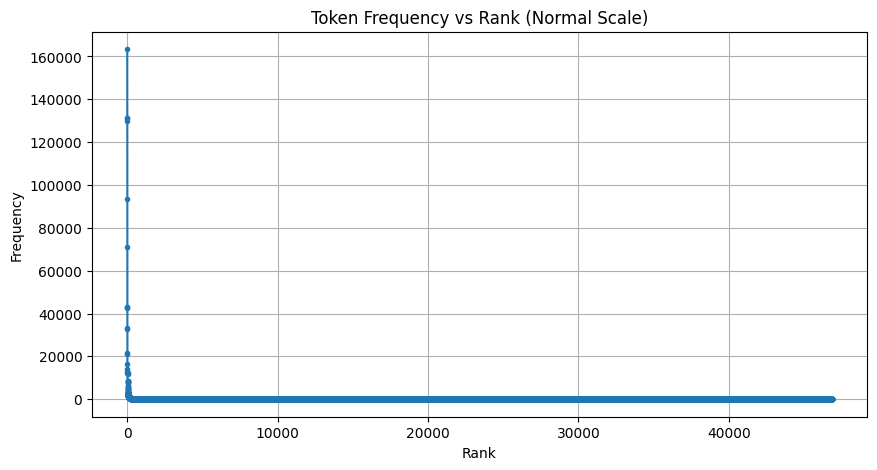

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(ranks, frequencies, marker='.')
plt.title("Token Frequency vs Rank (Normal Scale)")
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

Plot the frequency vs rank graph but this time, with natural log for both

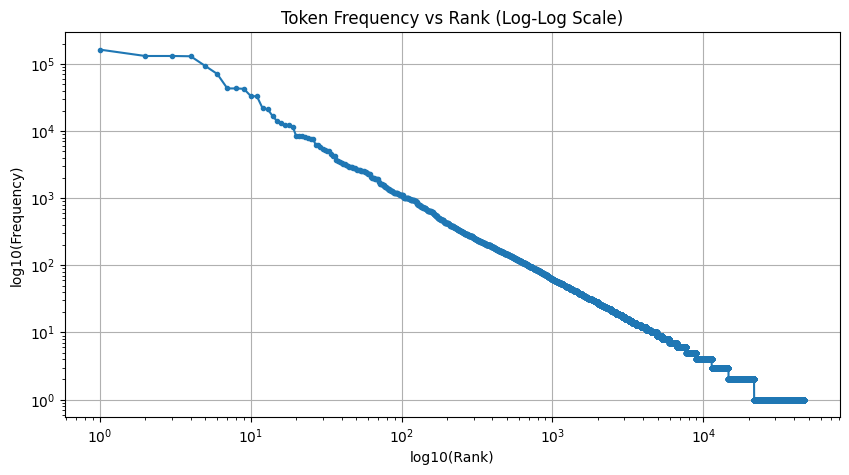

In [22]:
log_ranks = np.log10(ranks)
log_freqs = np.log10(frequencies)

plt.figure(figsize=(10, 5))
plt.loglog(ranks, frequencies, marker='.')
plt.title("Token Frequency vs Rank (Log-Log Scale)")
plt.xlabel("log10(Rank)")
plt.ylabel("log10(Frequency)")
plt.grid(True)
plt.show()

Applying Linear Regression on this one to fit the best line here

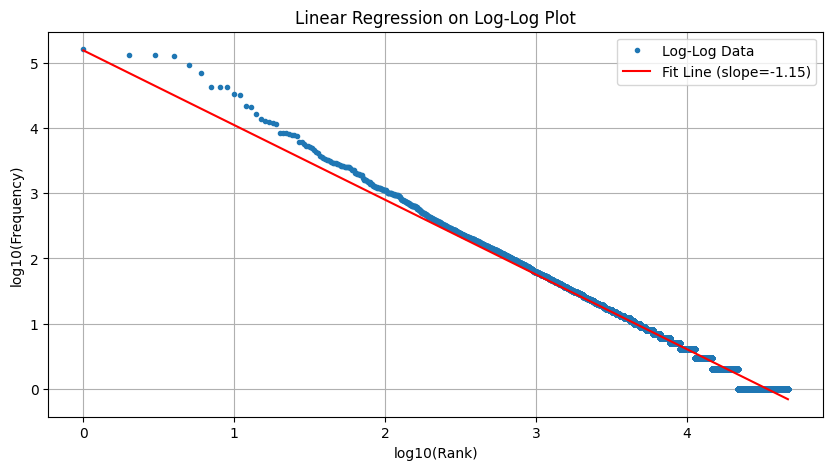

Slope of fitted line: -1.1469


In [23]:
slope, intercept, r_value, p_value, std_err = linregress(log_ranks, log_freqs)

plt.figure(figsize=(10, 5))
plt.plot(log_ranks, log_freqs, '.', label='Log-Log Data')
plt.plot(log_ranks, intercept + slope * log_ranks, 'r', label=f'Fit Line (slope={slope:.2f})')
plt.title("Linear Regression on Log-Log Plot")
plt.xlabel("log10(Rank)")
plt.ylabel("log10(Frequency)")
plt.legend()
plt.grid(True)
plt.show()

print(f"Slope of fitted line: {slope:.4f}")

<h3>Result Interpretation:</h3>

We observed that the slope of the fitted line on the log-log plot of token frequency vs. rank is −1.1469.

This means that the token usage in Python code (from the NumPy library) follows a Zipf-like power-law distribution. A small number of tokens (like def, =, :, etc.) are used very frequently, while most other tokens (like variable names and literals) are used very rarely.

The slope being close to −1 suggests that the structure of programming languages reflects similar optimization principles as natural language. Despite being more rigid and rule-based, code still shows efficient reuse of a limited token vocabulary, which aligns with the expectations from Zipf’s Law.<br>

This is not a special case — Zipf-like behavior is a general property of all large codebases, across all modern programming languages.

It reflects how humans write code:
<ol>
<li>Using patterns</li>
<li>Repeating structure</li>
<li>Minimizing cognitive load (reusing familiar tokens)</li>
</ol>